## From the previous session

***Exercise (homework)***: Use the code examples above to create a series of 100 model runs in which the pan factor, rainfall chloride concentration as well as the measured rainfall, evaporation and the dam water volume are all stochastic parameters.

In [1]:
# import the required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import norm

Just like last time, before we can do any calculations we need to import the file with the measured data.

In [2]:
df = pd.read_excel('data/water_balance_data.xlsx',
                   index_col=0,
                   parse_dates=True)
df.head()

,temperature,rh,rain,wl,volume,area,vpd,evaporation,Cl_sample,delta_18O_sample,delta_2H_sample
2013-08-25,11.25,81.0,0.0,-0.481333,1188.982978,1309.122275,0.253591,4.483474,20.401982,-4.32923,-16.581998
2013-08-26,10.75,89.5,0.4,-0.491695,1175.444157,1302.024401,0.135561,2.744956,NaN,NaN,NaN
2013-08-27,13.75,71.0,0.0,-0.498408,1166.708590,1297.418221,0.456128,4.896925,NaN,NaN,NaN
2013-08-28,14.00,83.0,0.0,-0.505052,1158.090844,1292.853550,0.271763,0.594952,NaN,NaN,NaN
2013-08-29,14.10,84.5,6.8,-0.505966,1156.907482,1292.225131,0.249396,2.668875,NaN,NaN,NaN


According to the assignment, all water balance components must have a random error. This means that the function `get_conc_cl` must be updated so tha a random error is calculated, and added to the original data. In the code cell below, the rainfall, evaporation and volume measurements are all modulated by adding a (circa) 10% measurement error, which is assumed to be normally distributed.

In [3]:
Cl_0 = 20 # g/m^3 = mg/l

def get_conc_cl(df, pan_factor=1.3, Cl_rain=2, sd1=0.033):
    # Calculate a normally distributed error that is roughly 10% (3 x a standard deviation 
    # of 3.3%) of the measured value
    e_rain = np.random.normal(0, sd1, len(df['rain'])) * df['rain']
    e_evap = np.random.normal(0, sd1, len(df['evaporation'])) * df['evaporation']
    e_volume = np.random.normal(0, sd1, len(df['volume'])) * df['volume']

    # Add the error to the orginal data
    df['rain'] = df['rain'] + e_rain
    df['evaporation'] = df['evaporation'] + e_evap
    df['volume'] = df['volume'] + e_volume

    # Proceed with the calculations as before
    df['P'] = df['area'] * df['rain'] / 1000.
    df['E'] = df['area'] * df['evaporation'] / (1000. * pan_factor)
    df['dV'] = -df['volume'].diff(periods=-1)
    df['I'] = df['P'] - df['E'] - df['dV']

    M_Cl_g = np.empty(len(df))
    conc_Cl = np.empty(len(df))

    P = df["P"].to_numpy()
    I = df["I"].to_numpy()
    V = df["volume"].to_numpy()
    for i, (Vi, Pi, Ii) in enumerate(zip(V, P, I)):
        if i == 0: # First day
            M_Cl_g[0] = Vi * Cl_0
            conc_Cl[0] = M_Cl_g[0] / Vi # Gives Cl_0 of course!
        else:
            M_Cl_g[i] = M_Cl_g[i - 1] + dM_P - dM_I
            conc_Cl[i] = M_Cl_g[i] / Vi

        dM_P = Cl_rain * Pi
        dM_I = conc_Cl[i] * Ii

    return conc_Cl

Even though the homework exercise asked to run the model 100 times, a number of 99 runs is done. The reason is that this allows drawing realizations for the pan factor and rainfall chloride concentration at exactly 1% intervals between the 1 and 99% percentiles.

In [4]:
N = 99
sample_percentiles = np.linspace(0.01, 0.99, N)

Remember that we sliced the array with randomly ordered indices to shuffle the selected values for the pan factors and rainfall chloride concentrations. Otherwise they'd both be increasing in tandem, which would bias the model outcomes.

In [5]:
indices = np.arange(N, dtype=int)

Draw values from the normally distributed pan factors with a mean of 1.3 and a standard deviation of 0.1 (using a relatively large value to emphasize the differences in model outcomes, the real range is likely to be smaller).

In [6]:
mu_p = 1.3
sigma_p = 0.1

dist_p = norm(loc=mu_p, scale=sigma_p)
pan_factors = dist_p.ppf(sample_percentiles)

np.random.shuffle(indices)
pan_factors = pan_factors[indices]

Also draw the realizations for the rainfall chloride concentration. Note that the mean and standard deviation were chosen such that the concentrations do not become negative.

In [7]:
mu_c = 4
sigma_c = 1

dist_c = norm(loc=mu_c, scale=sigma_c)
Cl_rains = dist_c.ppf(sample_percentiles)

np.random.shuffle(indices)
Cl_rains = Cl_rains[indices]

Running the model N times is extremely easy if we loop over the elements of the `pan_factors` and `Cl_rains` arrays simultaneously (using `zip`). Note that there is no need to add a counter to keep track of the number of model runs, it simply follows from the number of elements in the arrays.

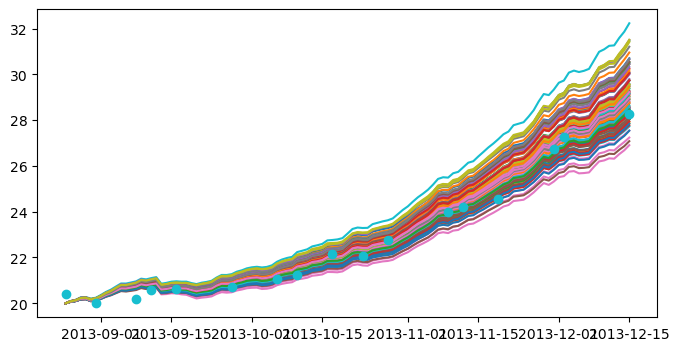

In [8]:
fig, ax = plt.subplots(figsize=(8,4))
for pan_factor, Cl_rain in zip(pan_factors, Cl_rains):
    Cl = get_conc_cl(df.copy(), pan_factor=pan_factor, Cl_rain=Cl_rain, sd1=0.033)
    ax.plot(df.index, Cl)
ax.plot(df.index, df["Cl_sample"], 'o')

Sometimes though, it is convenient to add a counter. For example, if we wish to store the outcome of each model run in a DataFrame. The script below uses a counter to add a unique column name to each column of `dfnew`, the DataFrame with the results.

In [9]:
dfnew = pd.DataFrame(index=df.index)
for n, (pan_factor, Cl_rain) in enumerate(zip(pan_factors, Cl_rains)):
    Cl = get_conc_cl(df.copy(), pan_factor=pan_factor, Cl_rain=Cl_rain, sd1=0.033)
    col_name = f"simulation_{n}"
    dfnew[col_name] = Cl

print(dfnew.head())

            simulation_0  simulation_1  simulation_2  simulation_3  \
2013-08-25     20.000000     20.000000     20.000000     20.000000   
2013-08-26     20.066286     20.077109     20.074447     20.080535   
2013-08-27     20.104039     20.116722     20.108448     20.127593   
2013-08-28     20.180991     20.200987     20.193599     20.216905   
2013-08-29     20.190326     20.211340     20.204144     20.227609   

            simulation_4  simulation_5  simulation_6  simulation_7  \
2013-08-25     20.000000     20.000000     20.000000     20.000000   
2013-08-26     20.094095     20.080509     20.080155     20.085908   
2013-08-27     20.140067     20.116687     20.119672     20.130408   
2013-08-28     20.234235     20.196843     20.204960     20.224234   
2013-08-29     20.245616     20.206903     20.215136     20.236753   

            simulation_8  simulation_9  ...  simulation_89  simulation_90  \
2013-08-25     20.000000     20.000000  ...      20.000000      20.000000   
2013

Now let's try to draw the mean value for each time step, and add some uncertainty bands (rather than plotting 99 colourful lines). One way to do this is to calculate the descriptive statistics using the `describe` function of Pandas. This function works on columns rather than rows so we have to transpose (that is, swap the rows for the columns) the DataFrame first using `dfnew.T`. The result of calling the `describe` method is stored in the DataFrame `dfstats`, which we also transpose so that the statistics for each time step appear per row for each time step.

In [10]:
dfstats = dfnew.T.describe()
dfstats = dfstats.T

print(dfstats.head())

            count       mean       std        min        25%        50%  \
2013-08-25   99.0  20.000000  0.000000  20.000000  20.000000  20.000000   
2013-08-26   99.0  20.077132  0.007040  20.062084  20.072454  20.076851   
2013-08-27   99.0  20.117521  0.010868  20.096915  20.110444  20.116687   
2013-08-28   99.0  20.203091  0.016801  20.171178  20.192491  20.201328   
2013-08-29   99.0  20.213400  0.017529  20.180240  20.202237  20.211340   

                  75%        max  
2013-08-25  20.000000  20.000000  
2013-08-26  20.080560  20.094554  
2013-08-27  20.122514  20.145381  
2013-08-28  20.213649  20.253182  
2013-08-29  20.224098  20.264647  


With these numbers we can now plot the median (50% percentile) model outcome as a blue line, and include shaded areas that represent the min-max and 25%-75% percentile ranges. Note the use of the `alpha` value, which controls the transparency of an object in the figure.

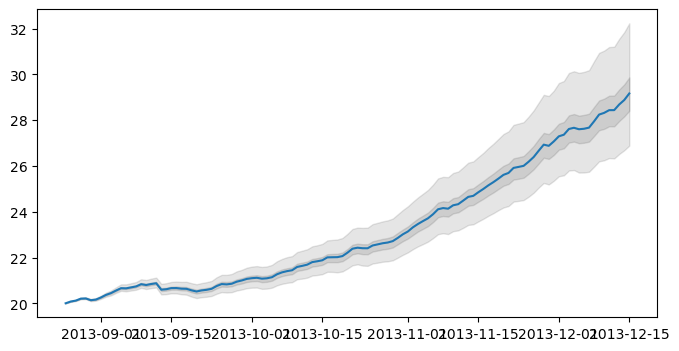

In [11]:
fig, ax = plt.subplots(figsize=(8,4))
ax.fill_between(dfstats.index, dfstats["min"], dfstats["max"], color='k', alpha=0.1)
ax.fill_between(dfstats.index, dfstats["25%"], dfstats["75%"], color='k', alpha=0.1)
ax.plot(dfstats.index, dfstats["50%"], color='C0');

In [12]:
dfinput = pd.DataFrame(data=[pan_factors, Cl_rains])
xl_writer = pd.ExcelWriter("water_balance_output.xlsx")
dfstats.to_excel(xl_writer, sheet_name="statistics")
dfinput.to_excel(xl_writer, sheet_name="input_parameters")
dfnew.to_excel(xl_writer, sheet_name="model_results")
xl_writer.close()